In [1]:
import numpy as np
import swiftestio as swio
import matplotlib.pyplot as plt
import timeit
import xarray as xr
from scipy.io import FortranFile
import pandas as pd
from dask.distributed import Client

In [2]:
workingdir = '/Users/daminton/work/Projects/Swiftest/Elliott_Performance/high_high_1500_1/'

In [3]:
config_file_name = workingdir + "param.in"
config = {}
config = swio.read_swiftest_config(config_file_name)
config['BIN_OUT'] = workingdir + config['BIN_OUT']
dims  = ['time','id', 'vec']

Reading Swiftest file /Users/daminton/work/Projects/Swiftest/Elliott_Performance/high_high_1500_1/param.in


In [4]:
dsframes =[]
pl = []
tp = []
nplarr = []
ntparr = []
with FortranFile(config['BIN_OUT'], 'r') as f:
    for t, npl, plid, pvec, plab, \
           ntp, tpid, tvec, tlab in swio.swiftest_stream(f, config):
        #print(f'Time = {t[0]}')
        plframe = np.expand_dims(pvec, axis=0)
        tpframe = np.expand_dims(tvec, axis=0)
        bd = []
        
        #Create xarray DataArrays out of each body type
        if npl[0] > 0:
            plxr = xr.DataArray(plframe, dims = dims, coords = {'time' : t, 'id' : plid, 'vec' : plab})
            bd.append(plxr)
        if ntp[0] > 0:
            tpxr = xr.DataArray(tpframe, dims = dims, coords = {'time' : t, 'id' : tpid, 'vec' : tlab})
            bd.append(tpxr)
        bdxr = xr.concat(bd, dim='time')
        #bdxr = bdxr.assign_coords({'npl' : npl[0], 'ntp' : ntp[0]})
        bdxr = bdxr.to_dataset(dim = 'vec')
        bdxr = bdxr.assign(npl=npl[0])
        bdxr = bdxr.assign(ntp=ntp[0])
        bdxr = bdxr.chunk()
        dsframes.append(bdxr)

In [5]:
ds = xr.concat(dsframes, dim='time')

In [10]:
workingdir = "/Volumes/Minton Data Archive/work archive/Projects/Swiftest/Pouplin-Mars-Disk/high_high_1500_1/savestate2/"
filehead = workingdir + 'bin'
ds = xr.open_mfdataset(f'{filehead}*.nc', combine='by_coords',concat_dim='time',parallel=False)

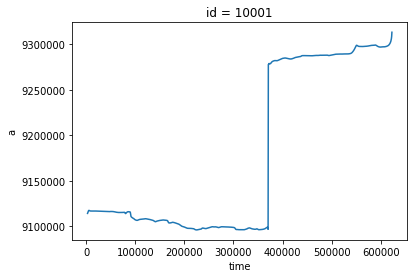